In [ ]:
!pip install --upgrade datasets

import seaborn as sns
import json
import math
import pandas as pd
import numpy as np
import pandas as pd
from collections import defaultdict

from huggingface_hub import login
from datasets import Dataset, DatasetDict, load_dataset
from scipy import stats

GENERATION WITH CONTEXT VS. WITHOUT

In [ ]:
dataset = load_dataset("Ramitha/unique-records-snippet-combination-all")
df = pd.DataFrame(dataset['rawcases'])
df = df.drop(["ILRAlign_with_problem_context_only_llama", "ILRAlign_with_problem_context_only_falcon", "ILRAlign_with_problem_context_only_gemma", "ILRAlign_with_problem_context_only_mistral"], axis=1)

In [ ]:
model_cols = [
    "ILRAlign_llama",
    "ILRAlign_falcon",
    "ILRAlign_gemma",
    "ILRAlign_mistral"
]
df_sub = df[["dataset", "snippet_percentage", "gold_standard_cos"] + model_cols]
df_long = df_sub.melt(
    id_vars=["dataset", "snippet_percentage", "gold_standard_cos"],
    value_vars=model_cols,
    var_name="base_model",
    value_name="ILRAlign_score"
)

df_long["base_model"] = df_long["base_model"].str.replace("ILRAlign_", "")

def compute_corr(group):
    return pd.Series({
        "correlation": group["ILRAlign_score"].corr(group["gold_standard_cos"])
    })

corr_table = (
    df_long.groupby(["dataset", "base_model", "snippet_percentage"])
    .apply(compute_corr)
    .reset_index()
)

pivot_table = corr_table.pivot_table(
    index=["base_model", "snippet_percentage"],
    columns="dataset",
    values="correlation"
).sort_index(level=["base_model", "snippet_percentage"]).round(4)

In [ ]:
pivot_table

dataset                          alqa  newsqa      sl
base_model snippet_percentage                        
falcon     0                   0.7631  0.7034  0.7201
           25                  0.7476  0.8144  0.7605
           50                  0.7246  0.8293  0.7576
           75                  0.8282  0.8127  0.7821
           100                 0.8236  0.8086  0.7767
gemma      0                   0.7606  0.3875  0.6135
           25                  0.7201  0.3921  0.6239
           50                  0.7019  0.3740  0.6347
           75                  0.7357  0.3830  0.6445
           100                 0.7536  0.3765  0.6590
llama      0                   0.9186  0.8541  0.9070
           25                  0.9237  0.8689  0.8924
           50                  0.9293  0.8983  0.9121
           75                  0.9332  0.8932  0.9080
           100                 0.9294  0.8959  0.8995
mistral    0                   0.7630  0.7377  0.7851
           25                  0.8032  0.7774  0.8473
           50                  0.8109  0.7933  0.8550
           75                  0.8285  0.7773  0.8579
           100                 0.8256  0.7946  0.8646

In [ ]:
mean_corr_table = pivot_table.groupby("snippet_percentage").mean().round(4)

In [ ]:
mean_corr_table

dataset,alqa,newsqa,sl
snippet_percentage,,,
0,0.8013,0.6707,0.7564
25,0.7986,0.7132,0.7810
50,0.7917,0.7237,0.7899
75,0.8314,0.7166,0.7981
100,0.8330,0.7189,0.7999


In [ ]:
def compute_corr_with_n(group):
    return pd.Series({
        "correlation": group["ILRAlign_score"].corr(group["gold_standard_cos"]),
        "n": len(group)
    })

corr_table = (
    df_long.groupby(["dataset", "base_model", "snippet_percentage"])
    .apply(compute_corr_with_n)
    .reset_index()
)

df_0 = corr_table[corr_table["snippet_percentage"] == 0].copy()
df_0 = df_0.rename(columns={"correlation": "correlation_0", "n": "n_0"})

def fisher_z(r):
    return np.arctanh(r)

def test_significance(r0, rX, n0, nX):
    if abs(r0) >= 1 or abs(rX) >= 1:
        return False
    z0 = fisher_z(r0)
    zX = fisher_z(rX)
    se = np.sqrt(1 / (n0 - 3) + 1 / (nX - 3))
    z = (z0 - zX) / se
    p = 2 * (1 - stats.norm.cdf(abs(z)))
    return p < 0.05

result_frames = []
for perc in [25, 50, 75, 100]:
    df_x = corr_table[corr_table["snippet_percentage"] == perc].copy()
    df_x = df_x.rename(columns={"correlation": "correlation_x", "n": "n_x"})
    merged = pd.merge(df_0, df_x, on=["base_model", "dataset"])
    merged[f"significant_{perc}"] = merged.apply(
        lambda row: test_significance(
            row["correlation_0"], row["correlation_x"],
            row["n_0"], row["n_x"]
        ),
        axis=1
    )
    result_frames.append(
        merged[["base_model", "dataset", f"significant_{perc}"]]
    )

from functools import reduce
final = reduce(
    lambda left, right: pd.merge(left, right, on=["base_model", "dataset"]),
    result_frames
)

final.columns = ["base_model", "dataset", "25", "50", "75", "100"]
final = final[["base_model", "dataset", "25", "50", "75", "100"]]
final

/tmp/ipython-input-1846148079.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_corr_with_n)


,base_model,dataset,25,50,75,100
0,falcon,alqa,False,True,True,True
1,gemma,alqa,True,True,False,False
2,llama,alqa,False,True,True,True
3,mistral,alqa,True,True,True,True
4,falcon,newsqa,True,True,True,True
5,gemma,newsqa,False,False,False,False
6,llama,newsqa,False,True,True,True
7,mistral,newsqa,True,True,True,True
8,falcon,sl,True,True,True,True
9,gemma,sl,False,False,False,True


EMBEDDING CONTEXT VS. WITHOUT

In [3]:
dataset1 = load_dataset("Ramitha/unique-records-snippet-combination-all")
df1 = pd.DataFrame(dataset1['rawcases'])
dataset2 = load_dataset("Ramitha/snippet-less-output-all-models-all")
df2 = pd.DataFrame(dataset2['rawcases'])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/rawcases-00000-of-00001.parquet:   0%|          | 0.00/26.1M [00:00<?, ?B/s]

Generating rawcases split:   0%|          | 0/24000 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

data/rawcases-00000-of-00001.parquet:   0%|          | 0.00/11.6M [00:00<?, ?B/s]

Generating rawcases split:   0%|          | 0/4800 [00:00<?, ? examples/s]

In [4]:
df_with_context = df1[df1["snippet_percentage"] == 100]
df_without_context = df2

df_combined = pd.concat([df_without_context, df_with_context])
model_cols = [
    "ILRAlign_without_context_llama",
    "ILRAlign_without_context_falcon",
    "ILRAlign_without_context_gemma",
    "ILRAlign_without_context_mistral",
    "ILRAlign_llama",
    "ILRAlign_falcon",
    "ILRAlign_gemma",
    "ILRAlign_mistral"
]
df_sub = df_combined[["dataset", "gold_standard_cos"] + model_cols]
df_long = df_sub.melt(
    id_vars=["dataset", "gold_standard_cos"],
    var_name="model",
    value_name="score"
)

df_long["context"] = df_long["model"].apply(
    lambda x: "without_context" if "without_context" in x else "with_problem_context_only"
)

df_long["base_model"] = df_long["model"].apply(
    lambda x: "llama" if "llama" in x else
              "falcon" if "falcon" in x else
              "gemma" if "gemma" in x else
              "mistral"
)

def compute_corr(group):
    return pd.Series({
        "correlation": group["score"].corr(group["gold_standard_cos"])
    })

corr_table = (
    df_long.groupby(["dataset", "base_model", "context"])
    .apply(compute_corr)
    .reset_index()
)

pivot_table = corr_table.pivot_table(
    index=["dataset", "base_model"],
    columns="context",
    values="correlation"
).reset_index().round(4)

pretty_table = pivot_table.set_index(["dataset", "base_model"])
pretty_table

/tmp/ipython-input-13846756.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_corr)


context             with_problem_context_only  without_context
dataset base_model                                            
alqa    falcon                         0.8236           0.8897
        gemma                          0.7536           0.2331
        llama                          0.9294           0.8978
        mistral                        0.8256           0.5637
newsqa  falcon                         0.8086           0.0805
        gemma                          0.3765           0.0149
        llama                          0.8959           0.8134
        mistral                        0.7946           0.7110
sl      falcon                         0.7767           0.1238
        gemma                          0.6590           0.1405
        llama                          0.8995           0.8677
        mistral                        0.8646           0.6361

In [5]:
summary_table = (
    corr_table.groupby(["dataset", "context"])["correlation"]
    .mean()
    .reset_index()
    .pivot(index="dataset", columns="context", values="correlation")
    .reset_index().round(4)
)

summary_table

context,dataset,with_problem_context_only,without_context
0,alqa,0.8331,0.646
1,newsqa,0.7189,0.405
2,sl,0.7999,0.442


In [6]:
def compute_corr_with_n(group):
    return pd.Series({
        "correlation": group["score"].corr(group["gold_standard_cos"]),
        "n": len(group)
    })

corr_table = (
    df_long.groupby(["dataset", "base_model", "context"])
    .apply(compute_corr_with_n)
    .reset_index()
)

df_without_context = corr_table[corr_table["context"] == "without_context"].copy()
df_with_context = corr_table[corr_table["context"] == "with_problem_context_only"].copy()

merged = pd.merge(
    df_without_context, df_with_context,
    on=["dataset", "base_model"],
    suffixes=("_without", "_with")
)

def fisher_z(r):
    return np.arctanh(r)

def compare_correlations(row):
    r1, r2 = row["correlation_without"], row["correlation_with"]
    n1, n2 = row["n_without"], row["n_with"]

    if abs(r1) >= 1 or abs(r2) >= 1:
        return pd.Series({
            "correlation_without": r1,
            "correlation_with": r2,
            "n_without": n1,
            "n_with": n2,
            "z_score": np.nan,
            "p_value": np.nan,
            "significant": False,
            "note": "Perfect correlation (±1), Z undefined"
        })

    z1 = fisher_z(r1)
    z2 = fisher_z(r2)
    se = np.sqrt(1 / (n1 - 3) + 1 / (n2 - 3))
    z = (z1 - z2) / se
    p = 2 * (1 - stats.norm.cdf(abs(z)))

    return pd.Series({
        "correlation_without": r1,
        "correlation_with": r2,
        "n_without": n1,
        "n_with": n2,
        "z_score": z,
        "p_value": p,
        "significant": p < 0.05,
        "note": ""
    })

results = merged.apply(compare_correlations, axis=1)
final_results = pd.concat([merged[["dataset", "base_model"]], results], axis=1)
final_results

/tmp/ipython-input-648736375.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_corr_with_n)


,dataset,base_model,correlation_without,correlation_with,n_without,n_with,z_score,p_value,significant,note
0,alqa,falcon,0.889663,0.823633,3200.0,3200.0,10.087112,0.000000e+00,True,
1,alqa,gemma,0.233081,0.753639,3200.0,3200.0,-29.741246,0.000000e+00,True,
2,alqa,llama,0.897766,0.929363,3200.0,3200.0,-7.720917,1.154632e-14,True,
3,alqa,mistral,0.563689,0.825627,3200.0,3200.0,-21.430669,0.000000e+00,True,
4,newsqa,falcon,0.080548,0.808603,3200.0,3200.0,-41.670680,0.000000e+00,True,
5,newsqa,gemma,0.014946,0.376532,3200.0,3200.0,-15.235444,0.000000e+00,True,
6,newsqa,llama,0.813409,0.895881,3200.0,3200.0,-12.551344,0.000000e+00,True,
7,newsqa,mistral,0.710960,0.794596,3200.0,3200.0,-7.782563,7.105427e-15,True,
8,sl,falcon,0.123817,0.776711,3200.0,3200.0,-36.485703,0.000000e+00,True,
9,sl,gemma,0.140543,0.658951,3200.0,3200.0,-25.966974,0.000000e+00,True,


TEMP BREAK EXPERIMENTS

In [7]:
dataset1 = load_dataset("Ramitha/unique-records-snippet-combination-all")
df1 = pd.DataFrame(dataset1["rawcases"])
dataset2 = load_dataset("Ramitha/snippet-less-output-all-models-all")
df2 = pd.DataFrame(dataset2["rawcases"])

df_with_context = df1[df1["snippet_percentage"] == 100]
df_without_context = df2
df_combined = pd.concat([df_with_context, df_without_context], ignore_index=True)

model_cols = [c for c in df_combined.columns if c.startswith("ILRAlign_")]

df_long = df_combined.melt(
    id_vars=["dataset", "gold_standard_cos", "temperature"],
    value_vars=model_cols,
    var_name="model",
    value_name="score"
)

df_long["context"] = df_long["model"].apply(
    lambda x: "without_context" if "without_context" in x else "with_problem_context_only"
)
df_long["base_model"] = df_long["model"].apply(
    lambda x: "llama" if "llama" in x else
              "falcon" if "falcon" in x else
              "gemma" if "gemma" in x else
              "mistral"
)

df_long = df_long.dropna(subset=["score"])

def assign_temp_bin(subdf):
    """Given sub‐data for a single (dataset, model, context),
       compute its temp bins based on quantiles and assign."""
    temps = subdf["temperature"]
    if temps.nunique() < 3:
        # fallback: everything “mid”
        return pd.Series(["mid"] * len(subdf), index=subdf.index)
    # Compute quantiles
    q_low = temps.quantile(1/3)
    q_high = temps.quantile(2/3)
    # assign
    def bin_fn(t):
        if t <= q_low:
            return "low"
        elif t <= q_high:
            return "mid"
        else:
            return "high"
    return subdf["temperature"].apply(bin_fn)

df_long["temp_bin"] = (
    df_long
      .groupby(["dataset", "base_model", "context"])
      .apply(assign_temp_bin)
      .reset_index(level=[0,1,2], drop=True)
)

group_cols = ["dataset", "base_model", "context", "temp_bin"]
corr_list = []
for keys, group in df_long.groupby(group_cols):
    corr = group["score"].corr(group["gold_standard_cos"])
    corr_list.append({
        "dataset": keys[0],
        "base_model": keys[1],
        "context": keys[2],
        "temperature": keys[3],
        "correlation": corr,
        "n": len(group)
    })
corr_df = pd.DataFrame(corr_list)

pivot_tbl = corr_df.pivot_table(
    index=["dataset", "base_model", "context"],
    columns="temperature",
    values="correlation"
).reset_index()

for col in ["low", "mid", "high"]:
    if col not in pivot_tbl.columns:
        pivot_tbl[col] = None

pivot_tbl = pivot_tbl[["dataset", "base_model", "context", "low", "mid", "high"]]
pretty = pivot_tbl.set_index(["dataset", "base_model", "context"])

print(pretty)


temperature                                        low       mid      high
dataset base_model context                                                
alqa    falcon     with_problem_context_only  0.725580  0.752735  0.838732
                   without_context            0.866664  0.810934  0.923423
        gemma      with_problem_context_only  0.508083  0.422267  0.315058
                   without_context            0.341623 -0.080684 -0.010224
        llama      with_problem_context_only  0.758364  0.839820  0.806649
                   without_context            0.809672  0.845188  0.865677
        mistral    with_problem_context_only  0.574350  0.728860  0.821762
                   without_context            0.165903  0.450736  0.582551
newsqa  falcon     with_problem_context_only  0.780304  0.812528  0.803427
                   without_context            0.741963  0.000219  0.702548
        gemma      with_problem_context_only  0.032242 -0.047274  0.554704
                   withou

/tmp/ipython-input-1520881184.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(assign_temp_bin)


/tmp/ipython-input-2007909467.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


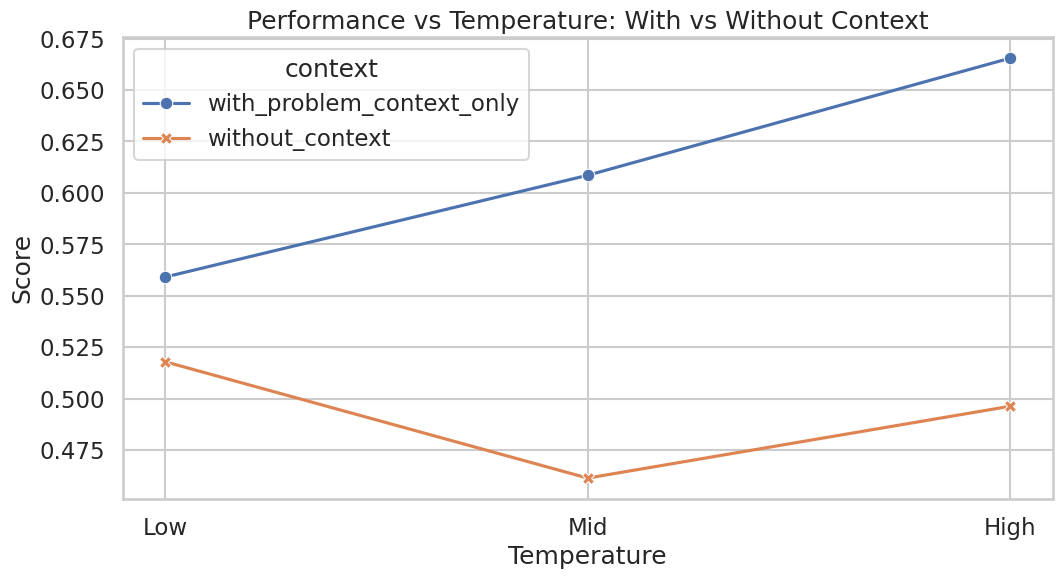

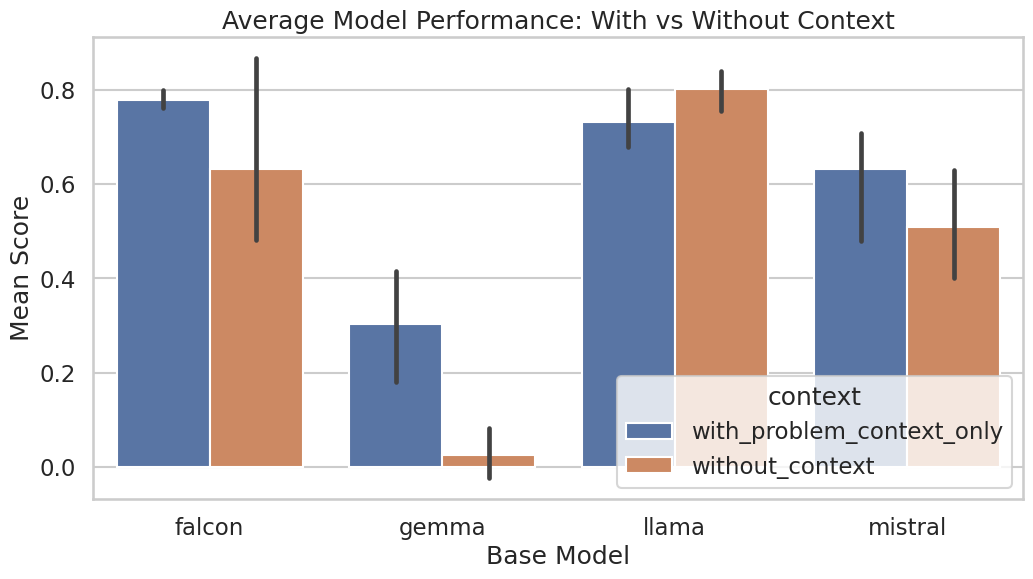

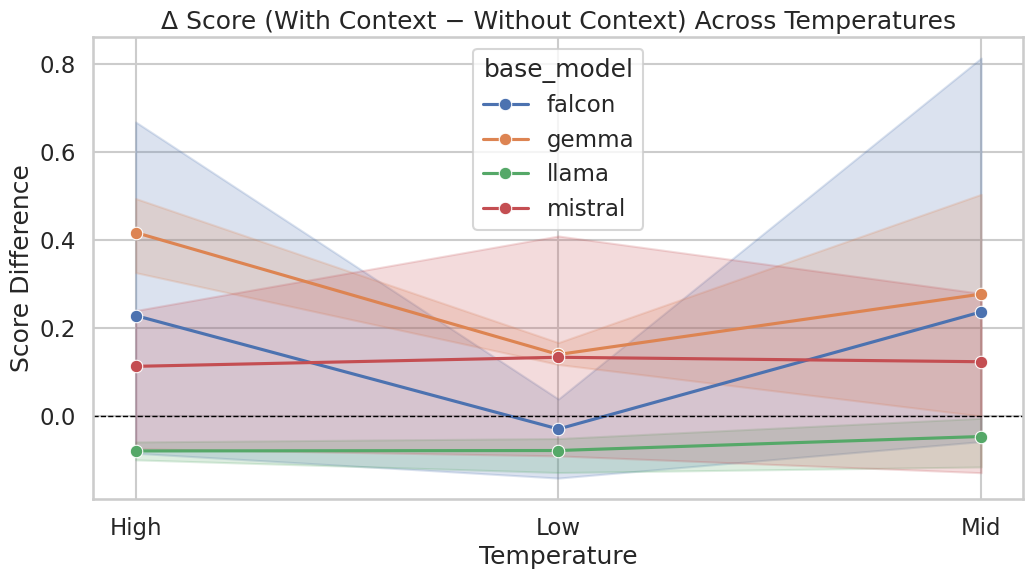

/tmp/ipython-input-2007909467.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


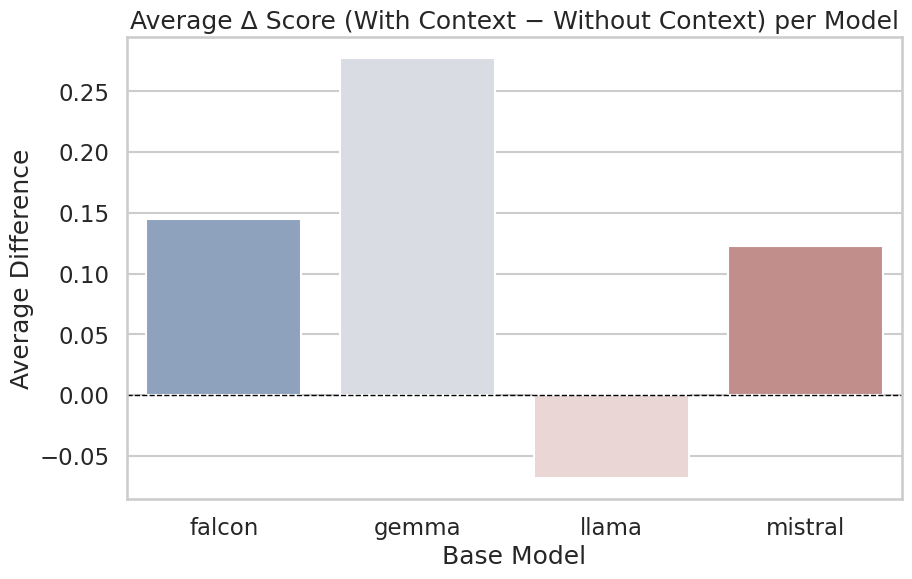

✅ All plots generated successfully (no heatmaps).


In [ ]:
df = pretty.reset_index().melt(
    id_vars=["dataset", "base_model", "context"],
    value_vars=["low", "mid", "high"],
    var_name="temperature",
    value_name="score"
)
df["temperature"] = df["temperature"].str.capitalize()

sns.set(style="whitegrid", context="talk", palette="deep")


plt.figure(figsize=(12,6))
sns.lineplot(
    data=df,
    x="temperature", y="score",
    hue="context", style="context",
    markers=True, dashes=False, ci=None
)
plt.title("Performance vs Temperature: With vs Without Context")
plt.ylabel("Score")
plt.xlabel("Temperature")
plt.show()


avg = (
    df.groupby(["dataset", "base_model", "context"], as_index=False)["score"]
    .mean()
)
plt.figure(figsize=(12,6))
sns.barplot(
    data=avg,
    x="base_model", y="score",
    hue="context"
)
plt.title("Average Model Performance: With vs Without Context")
plt.ylabel("Mean Score")
plt.xlabel("Base Model")
plt.show()

# Line plot: difference vs temperature per model
plt.figure(figsize=(12,6))
sns.lineplot(
    data=diff_df,
    x="temperature", y="difference",
    hue="base_model", marker="o"
)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Δ Score (With Context − Without Context) Across Temperatures")
plt.ylabel("Score Difference")
plt.xlabel("Temperature")
plt.show()

# Bar plot: average difference per model
avg_diff = diff_df.groupby("base_model", as_index=False)["difference"].mean()
plt.figure(figsize=(10,6))
sns.barplot(
    data=avg_diff,
    x="base_model", y="difference", palette="vlag"
)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Average Δ Score (With Context − Without Context) per Model")
plt.ylabel("Average Difference")
plt.xlabel("Base Model")
plt.show()

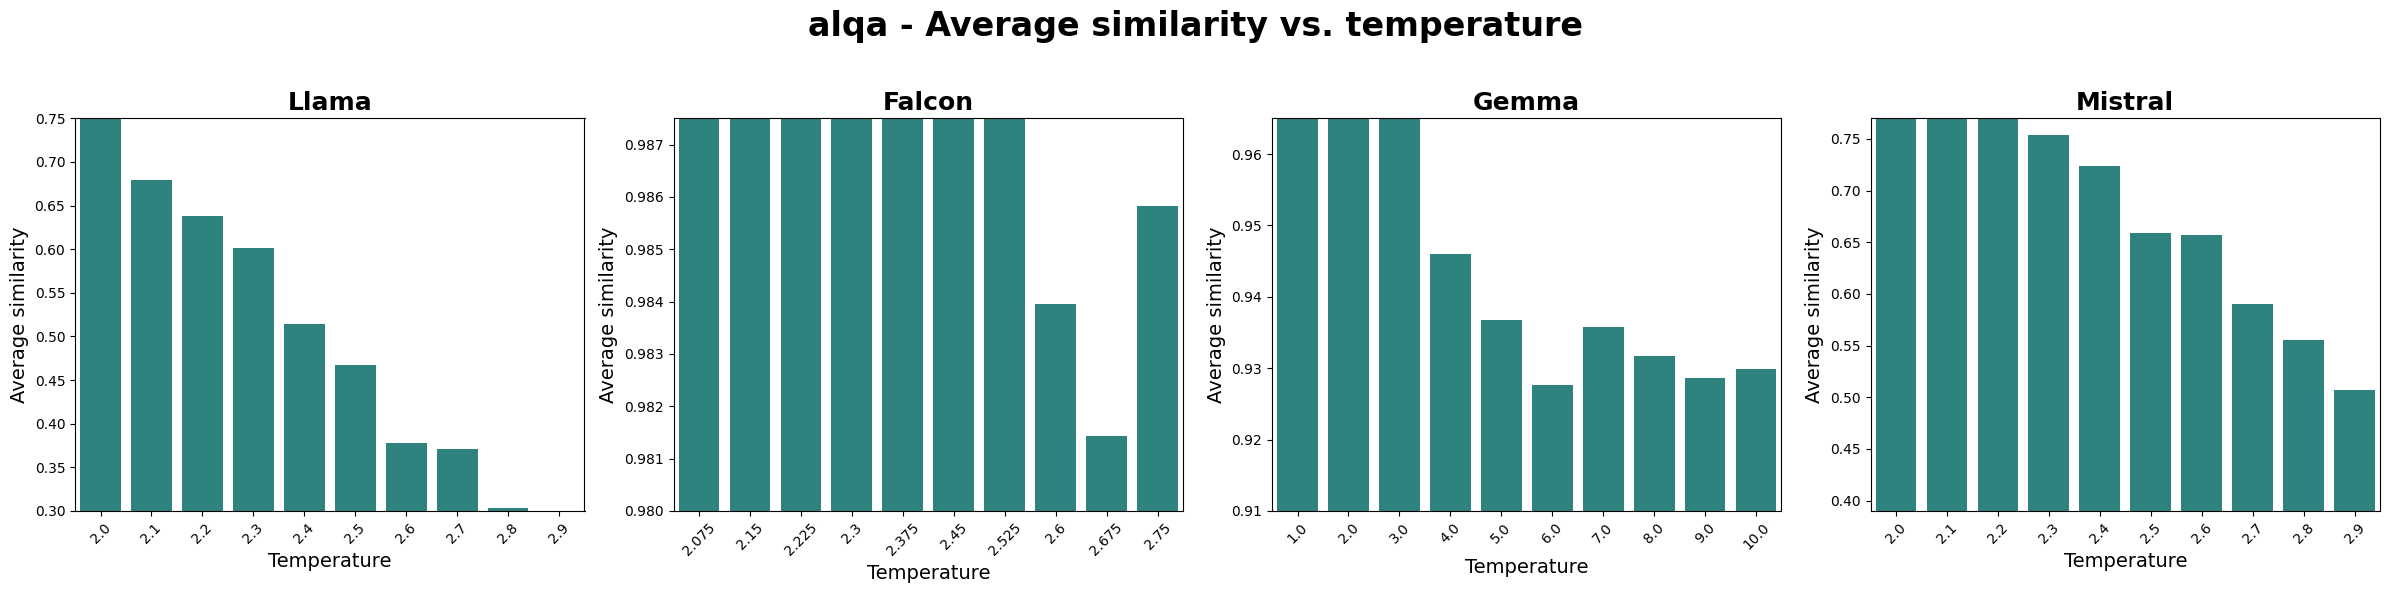

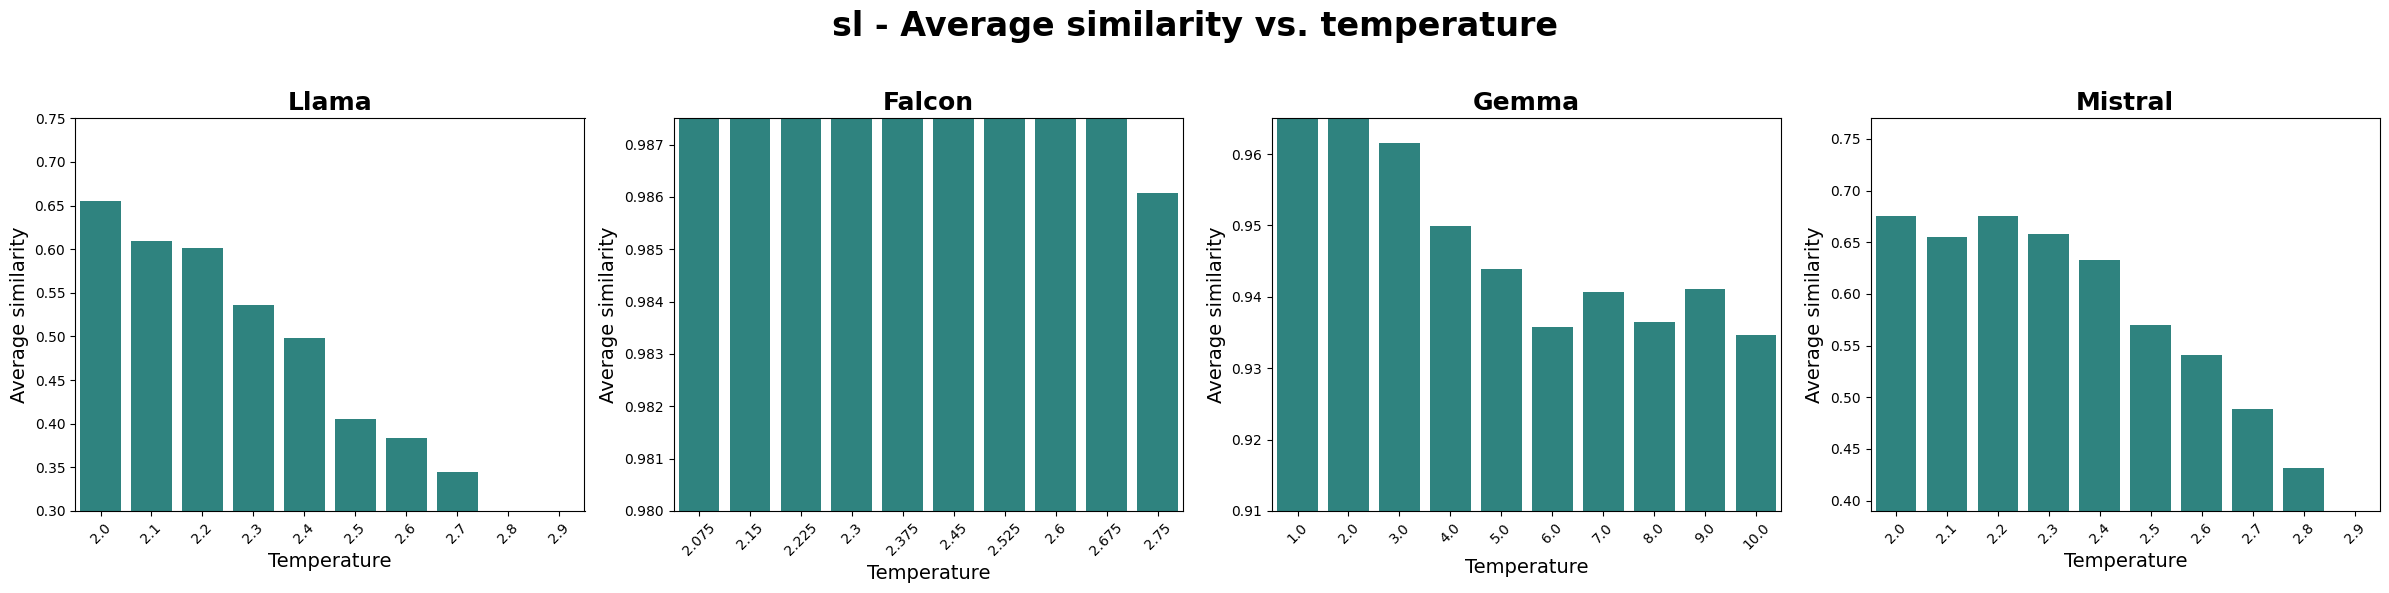

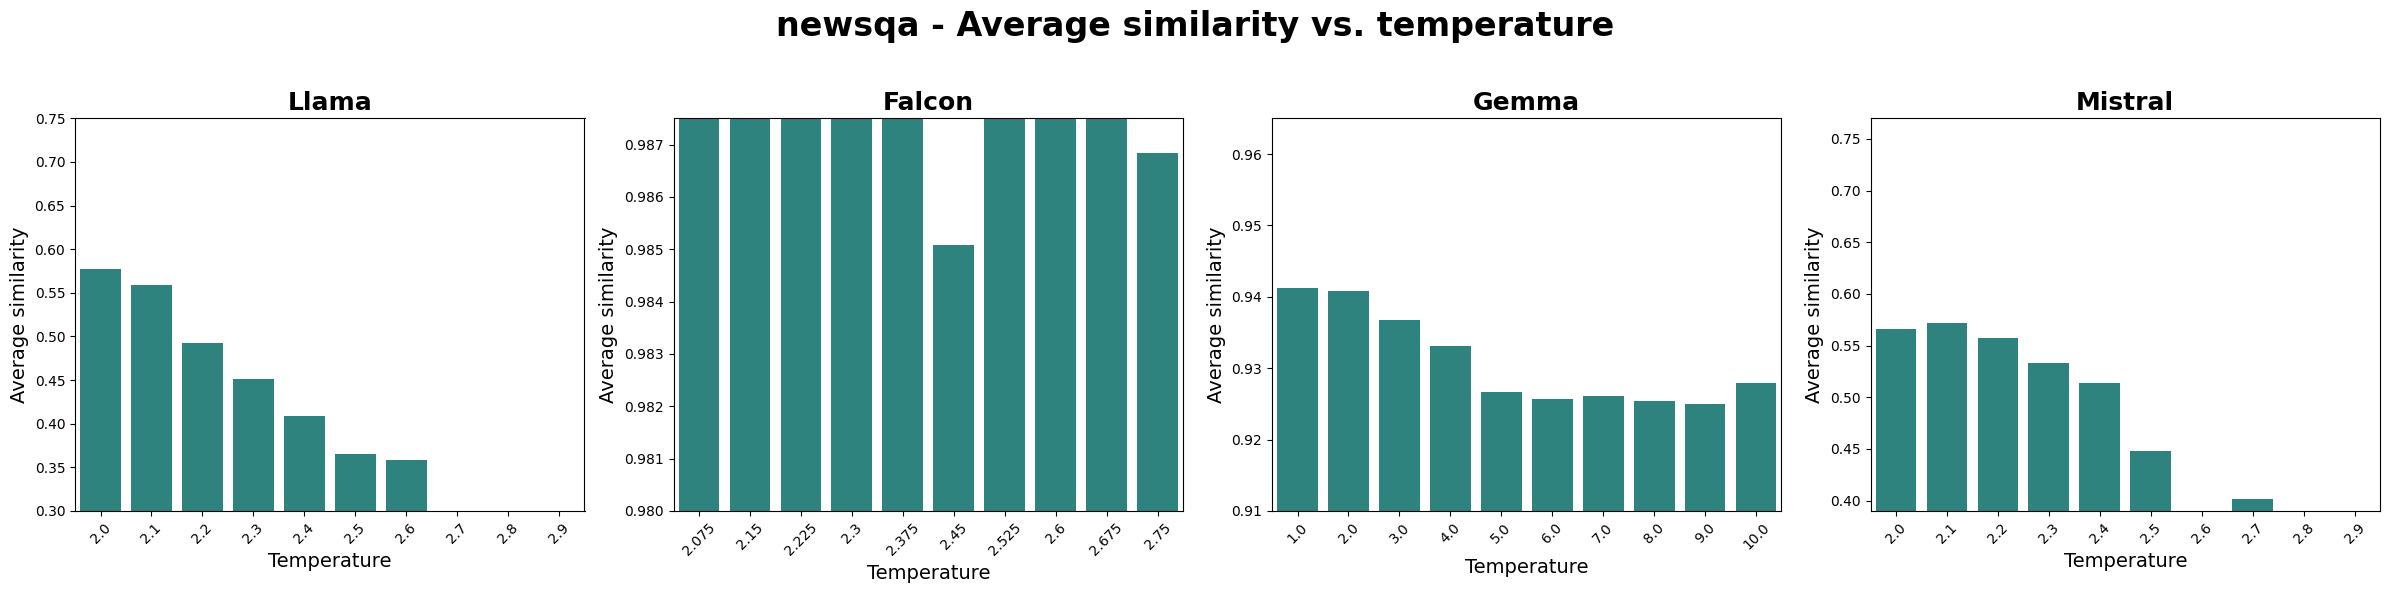

In [9]:
def plot_model_scores(df, model_name, ax, y1, y2):
    df_model = df[df['model'].str.contains(model_name, case=False, na=False)]
    grouped_df = (
        df_model.groupby('temperature', as_index=False)['gold_standard_cos']
        .mean()
    )
    sns.barplot(
        x='temperature',
        y='gold_standard_cos',
        data=grouped_df,
        color=sns.color_palette('viridis', 1)[0],
        ax=ax
    )
    ax.set_title(f'{model_name}', fontsize=18, weight='bold')
    ax.set_ylabel('Average similarity', fontsize=14)
    ax.set_xlabel('Temperature', fontsize=14)
    ax.set_ylim(y1, y2)
    ax.tick_params(axis='x', rotation=45)
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

datasets = df2['dataset'].unique()
for dataset in datasets:
    df_dataset = df2[df2['dataset'] == dataset]

    fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharey=False)
    fig.suptitle(f'{dataset} - Average similarity vs. temperature', fontsize=24, weight='bold')
    plot_model_scores(df_dataset, 'Llama', axes[0],  0.3, 0.75)
    plot_model_scores(df_dataset, 'Falcon', axes[1], 0.9800, 0.9875)
    plot_model_scores(df_dataset, 'Gemma', axes[2],0.91, 0.965)
    plot_model_scores(df_dataset, 'Mistral', axes[3], 0.39, 0.77)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
